In [1]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
import itertools as it
import dadi 
import dadi.DFE as DFE

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *
import os

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Analysis of complex demographic scenarios from PReFerSim

In this file, I will simulate changing population sizes and increase the level of complexity with each simulation. 

1. Bottleneck.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, 20k inds 10k gens ago, followed by 2k inds 2k gens ago)
`(https://github.com/dortegadelv/HaplotypeDFEStandingVariation/blob/master/Scripts/Sims/AncientBottleneck/ForwardSims/ParameterFile_4Ns-50.txt)`

In [4]:
## Need to create look-up tables matching the above demographic history...also run the gamma search over a relevant grid
gamma = -np.geomspace(1e-5,5e-3,20) #np.logspace(-0.5,2.5,25)
n = 1000
N = 10000
mu = 1.25e-8
cutoff = 2 # freq of 0.5%
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# for N=10,000 & gamma=-10, s=-0.0005

In [3]:
# s = -np.array([8e-5]) # gamma of 2, 20, 200 for N=10,000 & 4Ns
# for ig, g in enumerate(s):
#     with open('simfiles/ParameterFilesBottleneck.txt',"r") as file:
#         data = file.readlines()

#     data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
#     data[7] = 'FilePrefix: outfiles/Bottleneck{:.0e}\n'.format(-g)

#     with open('simfiles/ParameterFilesBottleneck.txt', 'w') as file:
#         file.writelines(data)
        
#     os.system("GSL_RNG_SEED=1004 GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesBottleneck.txt 1")

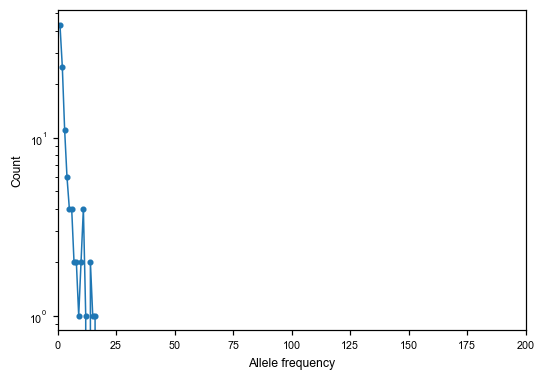

In [557]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/Bottleneck8e-03.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(20000,80000),np.repeat(2000,2000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
df1['sXl'] = df1['Xl']*200 
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
# plt.hist(df1['sXl'],50); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
# plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

sfs = moments.Spectrum(np.histogram(df1['sXl'],bins=range(0,202))[0])
moments.Plotting.plot_1d_fs(sfs)

SMS = np.zeros((len(Nc),200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

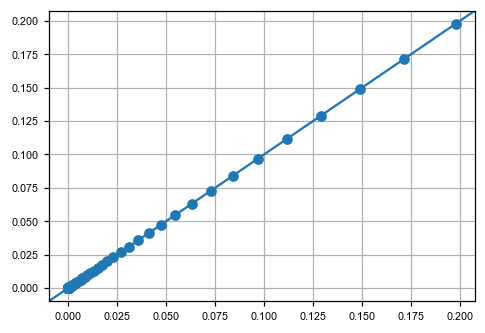

In [528]:
## CODE TO SHOW 1:1 RELATIONSHIP B/W MOMENTS & MY CALCULATIONS FOR *CHANGING POP SIZE*
# fs = moments.Spectrum(np.zeros(201)); fs[1] = 500
# fs.integrate(nu_func, 5000*4.1/len(Nc), gamma=-2*8, dt_fac=0.0005, theta=0)
# moments.Plotting.plot_1d_fs(fs)

# fsa = run_mom_iterate_changing(200, -16/10000, Nc/2, 500, {})

## plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar();

# plt.scatter(fs,fsa[-5000]); plt.axline((0,0),slope=1); plt.grid(); #plt.loglog()

# plt.plot(Nc[::-1]/Nc[0]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
# plt.plot([nu_func(t) for t in np.linspace(4.095,0,82000)]) ## 10,000 gens is 0.5

In [561]:
# 10**sp.optimize.minimize_scalar(get_ll_freqdemchanging,args=({'nu':nu_func,'T':4.09,'sfs':sfs,'p_misid':0,'theta':500},200),).x
# get_ll_freqdemchanging(np.log10(1),{'nu':nu_func,'T':4.05,'sfs':sfs,'p_misid':0,'theta':500},200)

sp.optimize.minimize_scalar(get_ll_freqagedemchanging,args=({'nu':nu_func,'Nc':Nc,'sms':SMSmask,'p_misid':0,'theta':2.5},200))
# get_ll_freqagedemchanging(np.log10(80),{'nu':nu_func,'Nc':Nc,'sms':SMSmask,'p_misid':0,'theta':2.5},200)
# plt.plot(np.geomspace(0.1,12,15),[-get_ll_freqagedemchanging(np.log10(8),{'nu':nu_func,'Nc':Nc[::-1],'sms':SMSmask,'p_misid':0,'theta':t},200) for t in np.geomspace(0.1,12,15)],'ko'); plt.grid(); 

     fun: 625.6329
    nfev: 27
     nit: 22
 success: True
       x: 1.9683270161291226

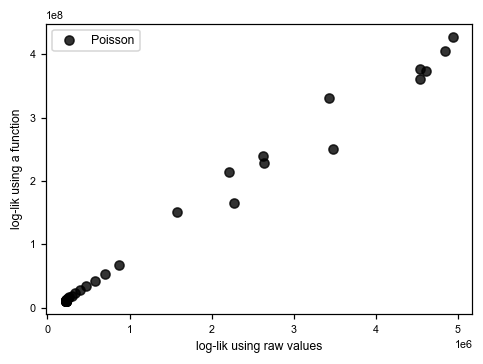

In [86]:
# llfreq = [np.sum(get_lp_xl(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
# llfreqpois = [np.sum(get_lp_xl_pois(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
# llfreqbin = [np.sum(get_lp_xl_bin(p_xa_s, g, dat[:,5], n=170, cutoff=1)) for g in gammas]
plt.scatter(llfreq, llfreqpois, color='k', alpha=0.8, label='Poisson'); plt.xlabel('log-lik using raw values'); plt.ylabel('log-lik using a function'); plt.legend()

In [129]:
## creating a database of P(X, a | s) with dicts for different s values
del up_xa_s
up_xa_s = {}
for ig, g in enumerate(gamma):
    ## unscaled probability - almost likelihood # original options: n, g, 2*Nc[::-1], ...
    up_xa_s[g] = run_mom_iterate_changing(n, 2*g, Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # up_xa_s[g] = run_mom_iterate_constant(20000, 2000, 0.5*g/Nc[0], N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

del p_xa_s
p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate(nu_func, 4.05, gamma=g*Nc[0], dt_fac=0.0005, theta=100)
    fs[fs<0] = 1e-250
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9


In [139]:
# dat = df1.sample(frac=0.5).to_numpy(dtype='int64')
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))
print(gamma[np.nanargmax(sin_onlyfreq)]*1e5, gamma[np.nanargmax(sin_onlyage)]*1e5)
mle = get_boot_ci(gamma,p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=25,cutoff=2)
mle.std(axis=0)*1e5

-259.936878074525 -187.42039366662618


array([49.472, 35.526])

In [140]:
estfreq, estage = np.array([1.9235, 7.117, 18.99, 70.25, 259.93])*1e-5, np.array([2.667, 7.117, 26.33, 70.25, 307.78])*1e-5
sefreq, seage = np.array([0.579, 1.326, 1.44, 5.317, 49.472])*1e-5, np.array([0.887, 1.367, 2.387, 5.327, 35.526])*1e-5
trues = np.array([1,3.2,10,32,100])*2.5e-5

(2e-06, 0.005)

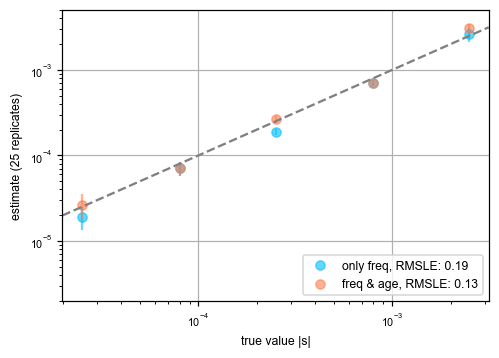

In [141]:
## plotting truth vs mean + CI estimates 
plt.scatter(trues,estfreq,color='deepskyblue',alpha=0.6,label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log(trues)-np.log(estfreq))**2)))); 
plt.scatter(trues,estage,color='coral',alpha=0.6,label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log(trues)-np.log(estage))**2)))); plt.legend(loc='lower right')
plt.errorbar(trues,estfreq,yerr=sefreq,color='deepskyblue',ls='none',alpha=0.6); plt.xlabel('true value |s|')
plt.errorbar(trues,estage,yerr=seage,color='coral',ls='none',alpha=0.6); plt.ylabel('estimate (25 replicates)')
plt.loglog(); plt.axline((0,0),(1e-3,1e-3),color='grey',linestyle='--'); plt.grid(); plt.ylim((2e-6,5e-3))

2. Expansion.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of recent expansion 200 gens ago to 200k inds -> didn't work, too complex a scenario - changing to a simpler 4x expansion...)

In [169]:
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
s = -np.array([2.5e-5,2.5e-4,2.5e-3,8e-5,8e-4]) # gamma of 2, 20, 200 for N=10000 & 4Ns
for ig, g in enumerate(s):
    with open('simfiles/ParameterFilesExpansion.txt',"r") as file:
        data = file.readlines()

    data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
    data[7] = 'FilePrefix: outfiles/Expansion{:.0e}\n'.format(-g)

    with open('simfiles/ParameterFilesExpansion.txt', 'w') as file:
        file.writelines(data)
        
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesExpansion.txt 3".format(rng.integers(100496)))

GSL_RNG_TYPE=mrg
GSL_RNG_SEED=36520



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000025
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-05

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16006078

Total number of mutations = 20005374


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=50361
GSL_RNG_TYPE=mrg
GSL_RNG_SEED=59200



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.002500
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-03

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 15997875

Total number of mutations = 19997401


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=4624



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000080
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-05

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16002395

Total number of mutations = 20002639


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=88220



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000800
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-04

Demographic History ( 2 epochs )

Ne = 5000	generations = 80000	F = 0.000000
Ne = 50000	generations = 2000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 16003032

Total number of mutations = 20002072


In [292]:
# gamma = -np.logspace(-0.5,2.5,30)
# 2 contains the 4x expansion from 10k to 40k, 3 contains the 10x expansion from 5k to 50k
df1 = pd.read_csv("outfiles/Expansion3e-05.3.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=6000)
# Nc = np.concatenate((np.repeat(10000,50000),np.repeat(40000,5000)))
Nc = np.concatenate((np.repeat(5000,80000),np.repeat(50000,2000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
df1['sXl'] = df1['Xl']*1000
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
# plt.hist(df1['sXl'],10); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],15); plt.xlabel('age of allele'); plt.show()
# plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

In [171]:
## creating a database of P(X, a | s) with dicts for different s values
del up_xa_s
up_xa_s = {}
n = 200
for ig, g in enumerate(gamma):
#     ## unscaled probability - almost likelihood
    up_xa_s[g] = run_mom_iterate_changing(n, 2*g, Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # up_xa_s[g] = run_mom_iterate_constant(20000, 2000, 0.5*g/Nc[0], N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

del p_xa_s
p_xa_s = {}
for g in gamma:
    # up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    # p_xa_s[g] = np.sum(up_xa_s[g], axis=0)
    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate(nu_func, 16.39, gamma=g*Nc[0], dt_fac=0.0005, theta=100)
    fs[fs<0] = 1e-250
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative change 9.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [10.000]
relative c

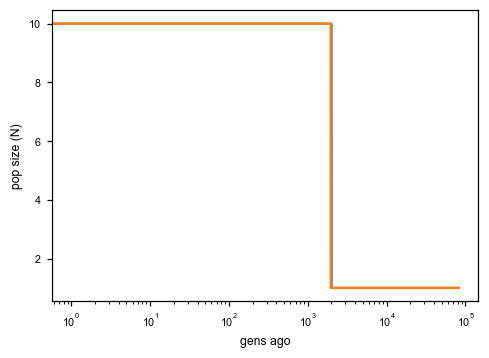

In [182]:
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
plt.plot([nu_func(t) for t in np.linspace(16.39,0,82000)]) # should align on top of real demography if unscaled by Nc[0]
# plt.imshow(up_xa_s[gamma[-1]],aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar()

In [179]:
## inference procedure (plot the loglik surfaces)
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))
print(gamma[np.argmax(sin_onlyfreq)]*1e4, gamma[np.argmax(sin_onlyage)]*1e4)
# mle = get_boot_ci(gamma,p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=50,cutoff=2)
# mle.std(axis=0)*1e4
# plt.plot(mle[:,0],'o',alpha=0.9); plt.plot(mle[:,1],'o',alpha=0.6); plt.axhline(-5e-4,ls='--',color='grey')

-319.36503936014617 -500.0


array([-1.000, -1.566, -2.451, -3.837, -6.008, -9.406, -14.726, -23.056,
       -36.096, -56.512, -88.476, -138.519, -216.866, -339.527, -531.566,
       -832.223, -1302.933, -2039.881, -3193.650, -5000.000])

In [22]:
# -1412467.660*0.5/2630619535.047, -1958844.339*0.5/8753100490.378
# get_bfq(sin_onlyfreq, gamma)[1]*0.5/get_bfq(sin_onlyfreq, gamma)[0], get_bfq(sin_onlyage, gamma)[1]*0.5/get_bfq(sin_onlyage, gamma)[0]
print(gamma[np.argmax(sin_onlyfreq)], gamma[np.argmax(sin_onlyage)])

-0.005 -0.005


In [470]:
# sin_onlyfreq, gamma*1e5
# -315544.716*0.5/7487071113.44, 1343653.57*0.5/9127767370.694
get_bfq(sin_onlyfreq, gamma), get_bfq(sin_onlyage, gamma)

In [125]:
estfreq, estage = np.array([2.67, 9.87, 26.33, 97.43, 259.9])*1e-5, np.array([1.0, 5.131, 13.69, 70.25, 259.9])*1e-5
sefreq, seage = np.array([4.544, 2., 2.764, 10.44, 47.11])*1e-5, np.array([3.022, 1.62, 3.3, 9.79, 45.15])*1e-5
trues = np.array([1,3.2,10,32,100])*2.5e-5

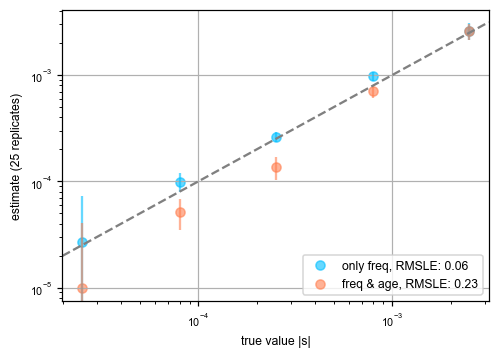

In [126]:
## plotting truth vs mean + CI estimates 
plt.scatter(trues,estfreq,color='deepskyblue',alpha=0.6,label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estfreq))**2)))); 
plt.scatter(trues,estage,color='coral',alpha=0.6,label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estage))**2)))); plt.legend(loc='lower right')
plt.errorbar(trues,estfreq,yerr=sefreq,color='deepskyblue',ls='none',alpha=0.6); plt.xlabel('true value |s|')
plt.errorbar(trues,estage,yerr=seage,color='coral',ls='none',alpha=0.6); plt.ylabel('estimate (25 replicates)')
plt.loglog(); plt.axline((0,0),(1e-3,1e-3),color='grey',linestyle='--'); plt.grid()

-1.0
-1.0


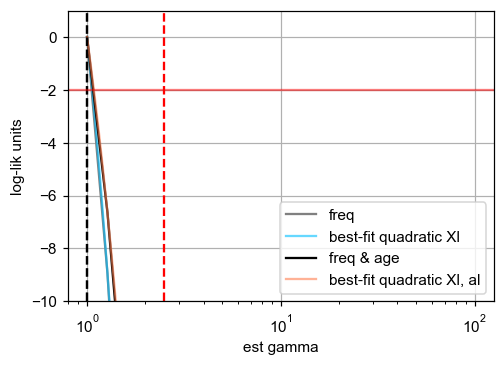

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'].iloc[0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

3. BottleneckpExpenasion.txt with point prob selection coefficient () and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, followed by exponential growth)

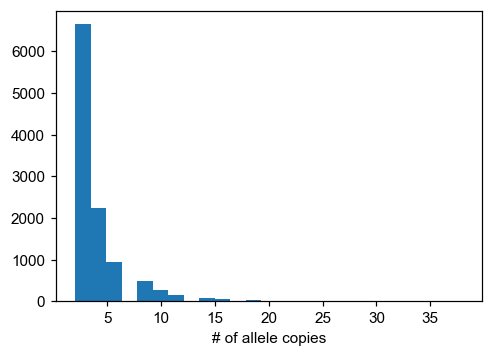

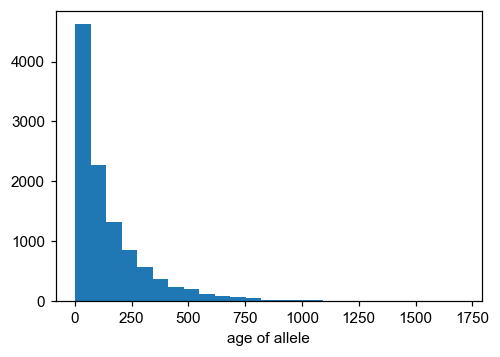

[]

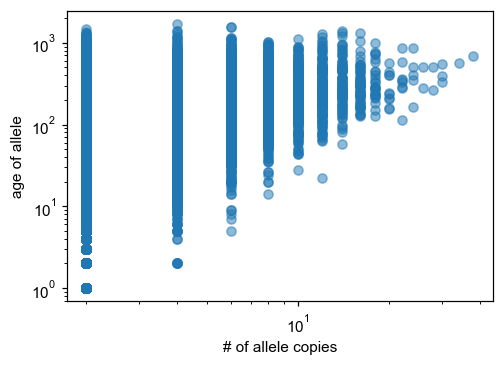

In [ ]:
df1 = pd.read_csv("PReFerSims/outfiles/BottleneckpExpansion10.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(10000,50000),np.repeat(2000,500),np.repeat(50000,3000)))/2
df1['sXl'] = df1['Xl']*n #rng.binomial(n=n, p=df1['Xl'])
df1['al'] = len(Nc)+1 - df1['al']
df1 
dat = df1.sample(frac=0.9).to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

[]

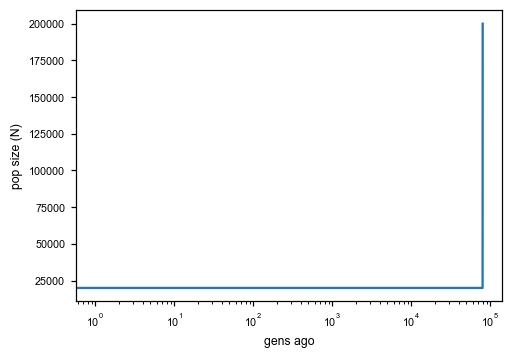

In [ ]:
# up_xa_s = {}
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()

In [ ]:
mle = get_boot_ci(gamma[:-1],p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=50,cutoff=2)
mle.mean(axis=0), mle.std(axis=0)

(array([-249.202, -126.549]), array([0.000, 11.382]))

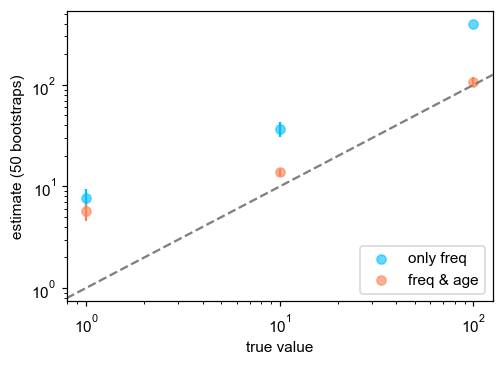

In [ ]:
## plotting truth vs mean + CI estimates 
plt.scatter([1.,10.,100.],[7.69,37.2,400],color='deepskyblue',alpha=0.6,label='only freq')
plt.scatter([1.,10.,100.],[5.69,13.8,107.5],color='coral',alpha=0.6,label='freq & age'); plt.legend(loc='lower right')
plt.errorbar([1.,10.,100.],[7.69,37.2,400],yerr=[1.7,6.2,0],color='deepskyblue',ls='none'); plt.xlabel('true value')
plt.errorbar([1.,10.,100.],[5.69,13.8,107.5],yerr=[1.1,1.1,12.8],color='coral',ls='none'); plt.ylabel('estimate (50 bootstraps)')
plt.loglog(); plt.axline((1,1),(100,100),color='grey',linestyle='--')

### Following manual from moments with Mende from Sierra Leone (MSL, 1000G) data 
#### (checking to see if we get similar DFE)

In [3]:
import pickle 
data = pickle.load(open("../testdata/sampleData/msl_data.bp", "rb"))

fs_syn = data["spectra"]["syn"]
fs_mis = data["spectra"]["mis"]
fs_lof = data["spectra"]["lof"]

u_syn = data["rates"]["syn"]
u_mis = data["rates"]["mis"]
u_lof = data["rates"]["lof"]

print("Diversity:")
print(f"synonymous:\t{fs_syn.pi():.2f}")
print(f"missense:\t{fs_mis.pi():.2f}")
print(f"loss of func:\t{fs_lof.pi():.2f}")

print()
print("Diversity scaled by total mutation rate:")
print(f"synonymous:\t{fs_syn.pi() / u_syn:.2f}")
print(f"missense:\t{fs_mis.pi() / u_mis:.2f}")
print(f"loss of func:\t{fs_lof.pi() / u_lof:.2f}")

Exception ignored in: <_io.FileIO name='../testdata/sampleData/msl_data.bp' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_79019/422844747.py", line 2, in <module>


Diversity:
synonymous:	8452.01
missense:	6991.16
loss of func:	95.16

Diversity scaled by total mutation rate:
synonymous:	58614.15
missense:	20408.81
loss of func:	3718.19


In [4]:
def model_func(params, ns):
    nuA, nuF, TA, TF, p_misid = params
    fs = moments.Demographics1D.snm(ns)
    fs.integrate([nuA], TA)
    nu_func = lambda t: [nuA * np.exp(np.log(nuF / nuA) * t / TF)]
    fs.integrate(nu_func, TF)
    return (1-p_misid) * fs + p_misid * fs[::-1]

p_guess = [2.0, 10.0, 0.3, 0.01, .02]
lower_bound = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
upper_bound = [10, 100, 1, 1, 1-1e-3]

opt_params = moments.Inference.optimize_log_fmin(
    p_guess, fs_syn, model_func,
    lower_bound=lower_bound, upper_bound=upper_bound)

model = model_func(opt_params, fs_syn.sample_sizes)
opt_theta = moments.Inference.optimal_sfs_scaling(model, fs_syn)
Ne = opt_theta / u_syn / 4

print("optimal demog. parameters:", opt_params)
print("inferred Ne:", f"{Ne:.2f}")

optimal demog. parameters: [2.215 5.298 0.555 0.041 0.020]
inferred Ne: 11372.91


In [250]:
# np.arange(opt_params[2],opt_params[3]+opt_params[2],0.5/Ne)
opt_params[2]+opt_params[3]

0.5953820251775782

In [350]:
## code to construct demography for a constant + continuous expansion/decline phase
## add an extra burn-in period of 3(?) coalescent time units up front to achieve equilibrium
# burnin = 3
# Nc_mis = []
# Nc_mis.append(np.repeat(opt_params[0]*2*Ne,int((burnin+opt_params[2])*2*Ne)))
# Nc_mis = Nc_mis[0].tolist()
# [Nc_mis.append((opt_params[0]*np.exp(np.log(opt_params[1]/opt_params[0])*(t-(opt_params[2]+burnin))/opt_params[3]))*2*Ne) for t in np.arange(burnin+opt_params[2],burnin+opt_params[3]+opt_params[2],0.5/Ne)]
# Nc_mis = np.array(Nc_mis)
# nu_func_mis = lambda t: [Nc_mis[int(t*2*Ne)]/Ne] # Nc[0] = Ne
# plt.plot(Nc_mis[::-1]/1e5); plt.semilogx(); plt.xlabel('time in gens'); plt.ylabel('pop size in 10k inds')
Nc_mis
# Nc = np.array(list(it.chain(*Nc)))

array([50389.182, 50389.182, 50389.182, ..., 120176.827, 120289.561,
       120402.402])

In [5]:
## creating a demographic function that contains the same pop sizes as above
# len(data['spectra']['mis'])
dat = np.zeros((int(np.sum(fs_mis[1:-1])),6),dtype='int')
ctr = 0
for ix in range(1,len(fs_mis)-1):
    dat[ctr:(ctr+int(fs_mis[ix])),5] = ix
    dat[ctr:(ctr+int(fs_mis[ix])),3] = np.exp(rng.normal(1.163*np.log(ix)+4.9,0.25,int(fs_mis[ix])))
    ctr += int(fs_mis[ix])

dat[dat[:,3]>80000,3] = 80000

[]

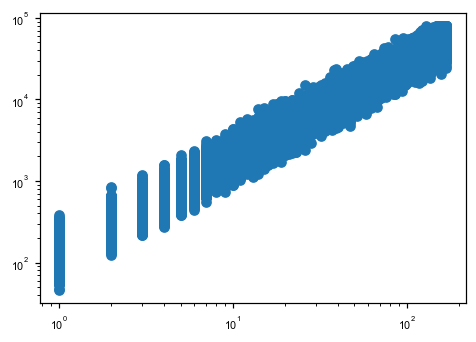

In [154]:
# rng.random.normal(1.163*np.log(25)+4.9,2,10)
# ctr:(ctr+int(fs_mis[ix])

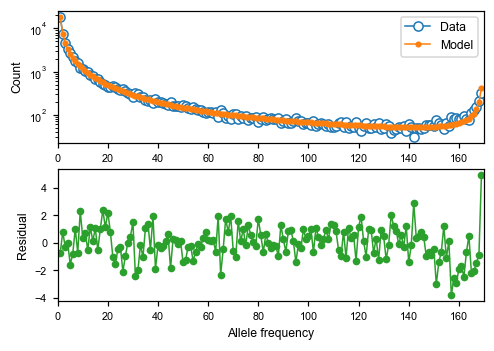

In [6]:
moments.Plotting.plot_1d_comp_multinom(model, fs_syn, residual="linear")

def selection_spectrum(gamma, h=0.5):
    rerun = True
    ns_sim = 100
    while rerun:
        ns_sim = 2 * ns_sim
        fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
        fs = moments.Spectrum(fs)
        fs.integrate([opt_params[0]], opt_params[2], gamma=gamma, h=h)
        nu_func = lambda t: [opt_params[0] * np.exp(
            np.log(opt_params[1] / opt_params[0]) * t / opt_params[3])]
        fs.integrate(nu_func, opt_params[3], gamma=gamma, h=h)
        if abs(np.max(fs)) > 10 or np.any(np.isnan(fs)):
            # large gamma-values can require large sample sizes for stability
            rerun = True
        else:
            rerun = False
    fs = fs.project(fs_syn.sample_sizes)
    fs[fs<0] = -fs[fs<0]
    return fs

spectrum_cache = {}
spectrum_cache[0] = selection_spectrum(0)

gammas = np.logspace(-3, 3, 30)
for gamma in gammas:
    spectrum_cache[gamma] = selection_spectrum(-gamma)

In [7]:
theta_mis = opt_theta * u_mis / u_syn

dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2
    + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=1):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return (1 - 0.0137) * fs + 0.0137 * fs[::-1]

def model_func_missense(params, ns):
    return dfe_func(params, ns, theta=theta_mis)

p_guess = [0.5, 10000]
lower_bound = [1e-4, 1e-1]
upper_bound = [1e1, 1e5]

opt_params_mis = moments.Inference.optimize_log_fmin(
    p_guess, fs_mis, model_func_missense,
    lower_bound=lower_bound, upper_bound=upper_bound,
    multinom=False)

model_mis = model_func_missense(opt_params_mis, fs_mis.sample_sizes)
print("optimal parameters:")
print("shape:", f"{opt_params_mis[0]:.4f}")
print("scale:", f"{opt_params_mis[1]:.1f}")
print("Log-likelihood:", moments.Inference.ll_multinom(model_mis, fs_mis))

optimal parameters:
shape: 0.1591
scale: 2466.4
Log-likelihood: -695.1244578923452


In [874]:
# np.sum(-model_mis.data + fs_mis.data*model.log() - sp.special.gammaln(fs_mis + 1.)), moments.Inference.ll_multinom(model_mis, fs_mis), moments.Inference.ll_multinom(dfe_func([alpha[10],beta[34]],170,theta_mis), fs_mis)
moments.Plotting.plot_1d_comp_Poisson(model_mis, fs_mis)

NameError: name 'model_mis' is not defined

### Trying to recapture the same estimates as above using our procedure and their data

#### Lessons learned:

1. **DO NOT NORMALIZE SFS**
2. Get an estimate of $\Theta$ by some PReFerSim magic (divide the total # of fixed/lost sites by the exp in $\gamma=0\ldots$?)
3. Leave $\gamma$ as positive in the cache, goes from -0.001 to 1000 on logscale
4. Take log10 for the estimates

In [9]:
sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,100]),method='L-BFGS-B',args=({'p_xa_s':spectrum_cache,'gamma':gammas,'sfs':fs_mis,'p_misid':0.0137,'theta':18000}),bounds=((-2,0),(0,4)))

      fun: 693.7730118228467
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.015, 0.006])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 13
     njev: 23
   status: 0
  success: True
        x: array([-0.801, 3.806])

In [447]:
del up_xa_s
up_xa_s = {}
up_xa_s[0] = run_mom_iterate_changing(170, 0, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
for ig, g in enumerate(gammas):
    up_xa_s[g] = run_mom_iterate_changing(170, -g*.5/Ne, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
    up_xa_s[g][:,np.arange(1,170)] = up_xa_s[g][:,np.arange(1,170)]/np.sum(up_xa_s[g][:,np.arange(1,170)])

## rescaling to keep mass similar to the SFS for a given gamma 
# up_xa_s[0] = up_xa_s[0]*spectrum_cache[0].sum()/up_xa_s[0].sum()
# for g in gammas:
#     up_xa_s[g] = up_xa_s[g]*spectrum_cache[g].sum()/up_xa_s[g].sum()

## Simulating data under the moments model using a Poisson likelihood

Using $\theta=100$ and $\gamma=-20$ with $n=500$ 

In [579]:
fs = moments.LinearSystem_1D.steady_state_1D(400, gamma=-20, theta=100)
fs = moments.Spectrum(fs)
fs.integrate([1], 3, gamma=-20, theta=100)
fs = fs.project([400]) 
fs[fs<0] = -fs[fs<0]

fsa = run_mom_iterate_constant(10000, 400, -20/10000, 10000, 400, {})
fsa[fsa<0] = -fsa[fsa<0]

# for i in range(1,len(sfs)):
#     fsa[:,i] *= fs[i]/fsa.sum(axis=0)[i]

sfs = np.zeros(len(fs))
for i in range(1,len(fs)-1):
    sfs[i] = rng.poisson(fs[i],1)

mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
SMS = np.zeros_like(fsa)
for i in range(1,SMS.shape[0]):
    for j in range(1,SMS.shape[1]):
        # if rng.binomial(1,0.25,1):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)

In [563]:
## estimate gamma using moments framework + sims
nsims = 12
parestfreq = np.zeros((3,nsims))
parestage = np.zeros((3,nsims))
for ig, g in enumerate([-100.,-10.,-1.]):
    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=g, theta=100)
    fs = moments.Spectrum(fs)
    fs.integrate([1], 3, gamma=g, theta=100)
    fs = fs.project([400]) 
    fs[fs<0] = -fs[fs<0]

    fsa = run_mom_iterate_constant(10000, 400, g/10000, 10000, 100, {})
    fsa[fsa<0] = -fsa[fsa<0]
    
    for n in range(nsims):
        sfs = np.zeros(len(fs))
        for i in range(1,len(fs)-1):
            sfs[i] = rng.poisson(fs[i],1)

        mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
        SMS = np.zeros_like(fsa)
        for i in range(1,SMS.shape[0]):
            for j in range(1,SMS.shape[1]):
                # if rng.binomial(1,0.25,1):
                SMS[i,j] = rng.poisson(fsa[-i,j],1)
        SMSmask = np.ma.array(SMS,mask=mask)

        parestfreq[ig,n] = 10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':100,'p_misid':0},200),).x
        parestage[ig,n] = 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':100,'N':10000,'p_misid':0,'gens':25000},200),).x
        print(parestfreq[ig,n], parestage[ig,n])

ValueError: operands could not be broadcast together with shapes (201,) (401,) 

In [454]:
nsims = 12
parestfreq0 = np.zeros(nsims)
parestage0 = np.zeros(nsims)
fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=0, theta=100)
fs = moments.Spectrum(fs)
fs.integrate([1], 3, gamma=0, theta=100)
fs = fs.project([200]) 
fs[fs<0] = -fs[fs<0]

fsa = run_mom_iterate_constant(50000, 200, 0, 10000, 100, {})
fsa[fsa<0] = -fsa[fsa<0]

for n in range(nsims):
    sfs = np.zeros(len(fs))
    for i in range(1,len(fs)-1):
        sfs[i] = rng.poisson(fs[i],1)

    mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
    SMS = np.zeros_like(fsa)
    for i in range(1,SMS.shape[0]):
        for j in range(1,SMS.shape[1]):
            # if rng.binomial(1,0.25,1):
            SMS[i,j] = rng.poisson(fsa[-i,j],1)
    SMSmask = np.ma.array(SMS,mask=mask)

    parestfreq0[n] = 10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':100,'p_misid':0},200),).x
    parestage0[n] = 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':100,'N':10000,'p_misid':0,'gens':50000},200),).x
    print(parestfreq0[n], parestage0[n])

4.35832402069063e-45 3.8334685225481076e-27
1.025260504435393e-13 1.631715470657777e-08
1.8939011768639983e-16 5.786397029720594e-07
2.909396036010453e-16 0.005974293677597228
2.059604108677772e-16 5.8194907795048106e-08
1.9507870966223034e-16 3.8334685225481076e-27
1.8873488471876144e-16 0.0017225394248566715
2.3422381671299823e-16 0.022435413432367685
0.007876306565805078 1.987957296260648e-07
2.255971195873182e-16 0.00992387418729326
1.043982209033598e-12 3.3535971054159076e-09
0.2562455056680452 0.021526836653309067


In [484]:
plt.plot([-100,-10,-1,0],np.append(np.std(parestfreq,axis=1)/np.std(parestage,axis=1),np.std(parestfreq0)/np.std(parestage0)),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); 

1.0

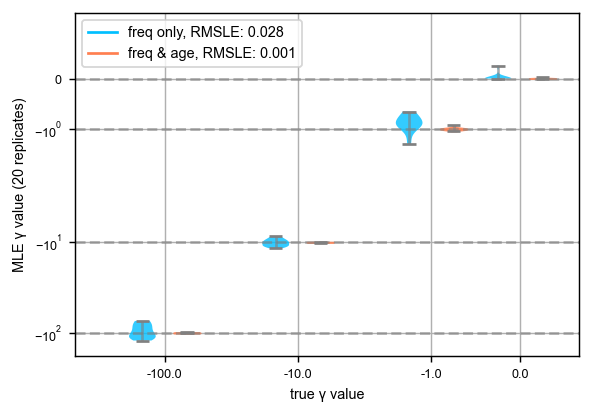

In [461]:
## SET YAXIS SCALE TO SEE HOW BIG THE SPREAD IS
def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')
    # plt.setp(bp['cbars'][0], color='deepskyblue')
    # plt.setp(bp['caps'][1], color='deepskyblue')
    # plt.setp(bp['whiskers'][0], color='deepskyblue')
    # plt.setp(bp['whiskers'][1], color='deepskyblue')
    # plt.setp(bp['fliers'][0], color='deepskyblue')
    # plt.setp(bp['medians'][0], color='deepskyblue')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)
    # plt.setp(bp['cbars'][1], color='coral')
    # plt.setp(bp['caps'][3], color='coral')
    # plt.setp(bp['whiskers'][2], color='coral')
    # plt.setp(bp['whiskers'][3], color='coral')
    # plt.setp(bp['fliers'][1], color='coral')
    # plt.setp(bp['medians'][1], color='coral')

fig = plt.figure(dpi=130)
ax = plt.axes()
s = np.array([-100.,-10.,-1.])
# hold(True)

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    vp = plt.violinplot([-parestfreq[i,:],-parestage[i,:]],positions=[3*i+1,3*i+2], widths=0.6,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6); plt.grid()

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
vp = plt.violinplot([parestfreq0,parestage0],positions=[9,10],widths=0.6,)
setViolColors(vp)
plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1.5,4.5,7.5,9.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog'); 

hB, = plt.plot([1,0],'-',color='deepskyblue')
hR, = plt.plot([1,0],'-',color='coral')
plt.xlabel('true γ value'); plt.ylabel('MLE γ value (20 replicates)')
plt.legend((hB, hR),('freq only, RMSLE: {:.3f}'.format(np.sqrt(np.mean((np.log10(-s)-np.log10(np.nanmean(parestfreq,axis=1)))**2))), 'freq & age, RMSLE: {:.3f}'.format(np.sqrt(np.mean((np.log10(-s)-np.log10(np.nanmean(parestage,axis=1)))**2)))),loc='upper left')
hB.set_visible(False)
hR.set_visible(False)

### Changing demographic history (Tennessen et al 2012) with Boyko DFE parameters
DFE: $\text{Beta}(\alpha=0.2,\beta=200)$

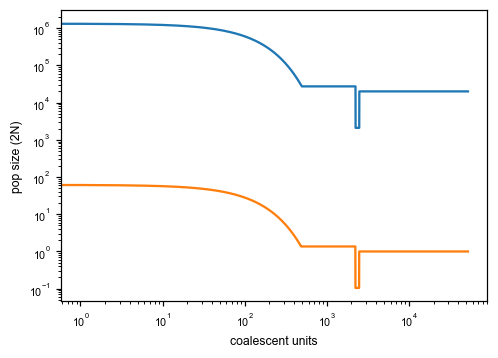

In [562]:
demo = np.loadtxt("simfiles/1kg_1.5_n10_prefersim_demo.txt", delimiter=" ", dtype='int')
Nc = []
[Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
nu_func = lambda t: [Nc[int(t*20000)]/Nc[0]] # Nc[0] = N = 12378
Nc = np.array(list(it.chain(*Nc)))
plt.plot(Nc[::-1]); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size (2N)');
plt.plot([nu_func(t) for t in np.linspace(2.624,0,len(Nc))]); plt.loglog(); plt.xlabel('coalescent units'); 

In [568]:
len(Nc)

52490

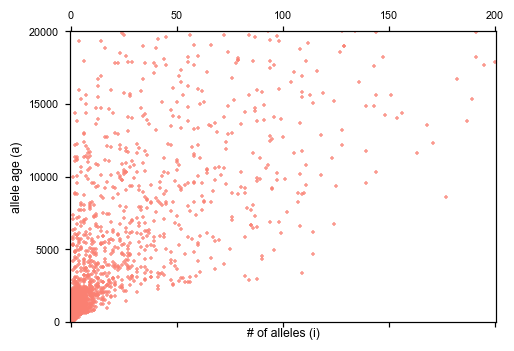

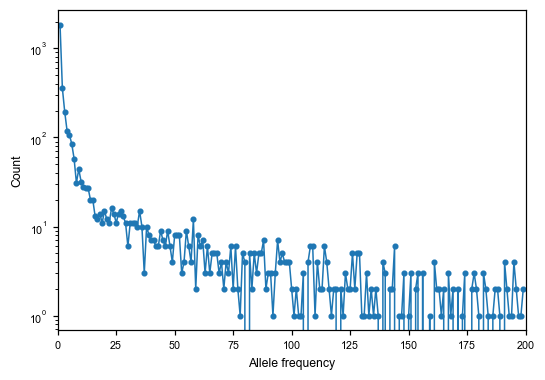

In [595]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*200)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = len(Nc)+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

SMS = np.zeros((len(Nc),200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,202))[0])
moments.Plotting.plot_1d_fs(sfs)

In [571]:
## creating a database of P(X, a | s) with dicts for different s values
del up_xa_s
up_xa_s = {}
gammas = np.logspace(-3,2,20)
up_xa_s[0] = run_mom_iterate_changing(200, 0, Nc/2, 4, {})
for ig, g in enumerate(gammas):
    fsa = run_mom_iterate_changing(200, -2*g/(Nc[0]/2), Nc/2, 4, {})
    fsa[(fsa<0) | (fsa>10)] = 0
    up_xa_s[g] = fsa
    
# del p_xa_s
p_xa_s = {}
for g in np.append(gammas,0):
    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-2*g, theta=800)
    fs = moments.Spectrum(fs)
    fs.integrate(nu_func, 2.624, gamma=-2*g, dt_fac=0.001, theta=800)
    fs = fs.project([200])
    fs[(fs<0) | (fs>1000)] = 0
    p_xa_s[g] = fs

N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.105]
relative change 0.89515
N_old,  [0.105] N_new [1.363]
relative change 11.99

In [608]:
sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.1,1000]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':len(Nc)},200))
# get_ll_freqagechanging(np.log10([0.2,10]),{'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':len(Nc)},200)
# sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.6,100]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200),bounds=((-2,0),(0,4)))
# get_ll_freqchanging(np.log10([0.2,20]),{'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200)

In [240]:
# nsims = 16
# estabfr, estabag = np.zeros((nsims,2)), np.zeros((nsims,2))
for n in range(1,nsims):
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))

    df1 = pd.read_csv("outfiles/gammaHuber17Unif.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
    df1['sXl'] = round(df1['Xl']*200)
    df1['al'] = 50000+1-df1['al']
    dat = df1.astype('int').to_numpy()

    SMS = np.zeros((50000,200+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(dat)):
        SMS[dat[i,3],dat[i,5]] += 1
    SMSmask = np.ma.array(SMS,mask=mask)

    sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,202))[0])
    
    estabag[n,] = 10**sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.6,10]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':50000,}),bounds=((-2,0),(0,4))).x
    estabfr[n,] = 10**sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.6,10]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,}),bounds=((-2,0),(0,4))).x

    print(estabag[n,],estabfr[n,])
# get_ll_freqchanging(np.log10([0.2,400]),{'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200)
# get_ll_freqagechanging(np.log10([0.8,400]),{'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0},200)

# 10**sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.6,600]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':len(Nc)}),bounds=((-2,0),(0,4))).x, 
# 10**sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,500]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,}),bounds=((-2,0),(0,4))).x

[0.165 334.189] [0.176 281.523]
[0.197 264.138] [0.205 233.719]
[0.188 292.165] [0.201 246.488]
[0.159 532.103] [0.174 402.656]
[0.165 655.958] [0.172 585.744]
[0.203 201.437] [0.196 255.593]
[0.160 480.478] [0.182 327.571]
[0.175 378.110] [0.181 361.668]
[0.161 505.357] [0.177 389.682]
[0.189 292.161] [0.207 226.242]
[0.195 222.061] [0.206 198.459]
[0.181 311.764] [0.190 281.539]
[0.169 429.488] [0.182 355.122]
[0.151 725.878] [0.167 528.811]
[0.182 283.310] [0.190 268.766]


In [ ]:
# plt.scatter(estabfr[:,0],estabfr[:,1],color='deepskyblue',alpha=0.8,label='freq only'); plt.ylabel(r'$\beta$')
# plt.scatter(estabag[:,0],estabag[:,1],color='coral',alpha=0.8,label='freq & age'); plt.plot(0.2,200,'k*',markersize=12,label='true value')
# plt.plot(np.mean(estabfr[:,0]),np.mean(estabfr[:,1]),'*',color='deepskyblue',markersize=15); plt.legend(); plt.xlabel(r'$\alpha$'); 
# plt.plot(np.mean(estabag[:,0]),np.mean(estabag[:,1]),'*',color='coral',markersize=15); plt.grid(); 
estabag.mean(axis=0), estabfr.mean(axis=0)

(array([0.177, 383.025]), array([0.189, 320.219]))

In [38]:
# fsa_est = get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},100)
# fsa_est.shape, fsa.shape, SMS.shape
# SMS[:5,:5], fsa[-5:,:5]
# SMS.nonzero()[0][-10:]
# np.allclose(fsa[:19955,:],fsa_est)
# SMS.sum()*2/sfs.sum()
# fsa.sum()*2/fs.sum()
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':120,'N':10000,'p_misid':0,'gens':10000},200),tol=1e-2,bracket=(-2,3))
# get_ll_freqageconstant(np.log10(20),{'sms':SMSmask,'theta':100,'N':10000,'p_misid':0,'gens':10000},200)

     fun: 33820.174146660334
    nfev: 14
     nit: 10
 success: True
       x: 1.3459852991626884

In [560]:
thetas = np.linspace(1,10,10)
# gtff, ltff = [], []
gtfa, ltfa = [], []
for t in thetas:
    # res = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},250),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ltff.append(res.fun)
    # gtff.append(10**res.x)
    res = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':10000},400))
    ltfa.append(res.fun)
    ## ltfa.append(get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250))
    gtfa.append(10**res.x)

KeyboardInterrupt: 

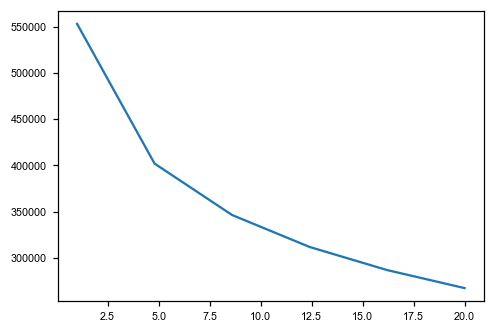

In [581]:
# plt.plot([4,10,20,40,100],[1300,850,470,290,180],'ko',); plt.semilogx(); plt.xlabel(r'$\hat \gamma$'); plt.ylabel(r'$\theta$'); plt.grid(); plt.axhline(100,color='grey',ls='--')
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':100,'N':10000,'p_misid':0},250),tol=1e-2,bracket=(-2,3))
# 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':10000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3)).x 
# np.polyfit(thetas,-np.array(ltfa),2)
# thetas[np.argmin(ltfa)]
plt.plot(np.linspace(1,20,6),[get_ll_freqageconstant(np.log10(20),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':40000},400) for t in np.linspace(1,20,6)])

In [555]:
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':330,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250),tol=1e-2,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':120,'p_misid':0},250),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
# plt.scatter(thetas[:4],-np.array(ltff),color='deepskyblue',alpha=0.7,); plt.axvline(100,color='grey'); plt.grid(); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.show()
# plt.scatter(thetas,-np.array(ltfa),color='coral',alpha=0.7,); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.axvline(100,color='grey'); plt.grid(); plt.show()
# plt.scatter(thetas[:4],gtff,color='deepskyblue',alpha=0.8,label='freq only'); plt.axhline(20,color='red'); plt.xlabel(r'$\theta$'); 
# plt.scatter(thetas,gtfa,color='coral',alpha=0.8,label='freq & age'); plt.ylabel(r'$\gamma$'); plt.legend(); plt.grid(); plt.show()

(array([0.100, 0.545, 0.991, 1.436, 1.882, 2.327, 2.773, 3.218, 3.664,
        4.109, 4.555, 5.000]),
 [165210.72552091465,
  124695.93659210317,
  110567.86414550057,
  101857.93498376275,
  95574.9562863296,
  90675.94784506383,
  86672.71811404868])

Text(0, 0.5, 'gens')

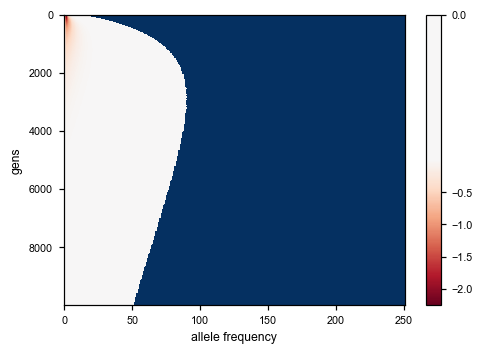

In [121]:
## plot residuals of true and estimated gamma & theta
fst = run_mom_iterate_constant(10000, 250, -100/10000, 10000, 1, {})
# plt.imshow(((fst-fsa)/np.sqrt(fst))[::-1],aspect='auto',cmap='RdBu',norm=colors.TwoSlopeNorm(vcenter=0)); plt.colorbar(); plt.xlabel('allele frequency'); plt.ylabel('gens')
np.sqrt(np.nanmean((np.log(fst+1)-np.log(fsa+1))**2))

In [559]:
## log-lik 2D surface over theta and gamma
# thetas = np.linspace(0.1,5,10)
# gammas = np.logspace(-1,2,10,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':40000},400)
#         ll2d[it,ig] = get_ll_freqconstant(np.log10(g),{'sfs':sfs,'theta':t,'N':10000,'p_misid':0,},200)

# plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,20,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,20,3),labels=np.round(gammas[::3],1)); 
# plt.axvline(14.7,color='red'); plt.axhline(2.1,color='red'); plt.plot(15,2,'kx')
# np.argwhere(ll2d==np.min(ll2d))

172973.8562246939

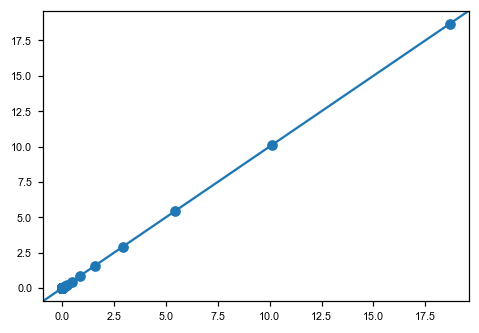

In [30]:
## CODE TO SHOW 1:1 RELATIONSHIP B/W MOMENTS & MY CALCULATIONS

fst = moments.Spectrum(np.zeros(251))
fst[1] = 100
fst.integrate([1], 200/20000, gamma=-13, theta=0)

# plt.scatter(fs,fst); plt.axline((0,0),slope=1); plt.loglog()
# np.allclose(fs,fst)

fsa = run_mom_iterate_constant(2000, 250, -13/10000, 10000, 100, {})

# # moments.Plotting.plot_1d_fs(fs)
plt.scatter(fst,fsa[-200,:]); plt.axline((0,0),slope=1); #plt.loglog()
# np.corrcoef(fst[1:], fsa[-100,1:])
# thetas[4]

In [664]:
fst[1:10], fsa[-200,1:10]

(Spectrum([18.93336205799307 10.302703110259207 5.597568104280357 3.0365138534551437
  1.6446819032053575 0.889451982291373 0.4802864174637022
  0.2589516207447414 0.13940581319115108], folded=False, pop_ids=None),
 array([18.936, 10.302, 5.597, 3.036, 1.645, 0.889, 0.480, 0.259, 0.139],
       dtype=float32))

In [49]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/ConstantSize10.0.3.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*200)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = 20000+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

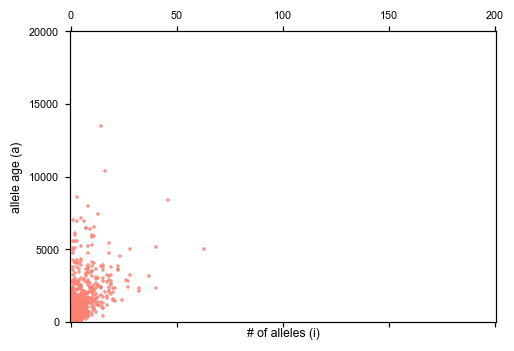

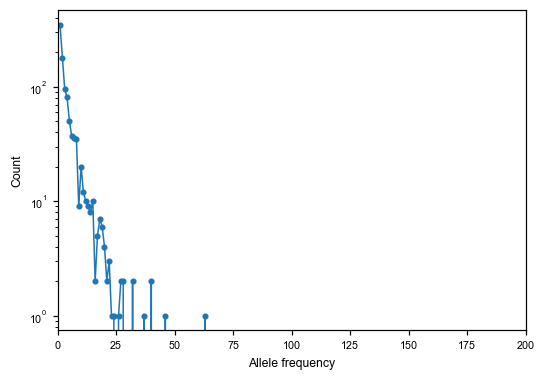

In [50]:
## create a SMS (matrix) instead of SFS
SMS = np.zeros((20000,200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    if (dat[i,3]<50000) & (dat[i,5]<200):
        SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()
# plt.plot(nzidx[1],nzidx[0],'ko'); plt.loglog()
# plt.plot(np.ravel(SMS.sum(axis=1)),'ko',); plt.semilogy()

# prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
# dadisfs = np.zeros((2000+1,)).astype('int')
# for n in range(0, len(prfsim.columns)-1):
#     dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

# f = open("outfiles/ConstantSize6.95.2.dadi.sfs_out.txt", "w")
# f.write("201 unfolded\n")
# f.write(' '.join(map(str, dadisfs)))
# f.close()

sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,202))[0])
moments.Plotting.plot_1d_fs(sfs)

# plt.scatter(np.arange(1,172),fs_mis,color='goldenrod',alpha=0.6,label='moments'); plt.scatter(np.arange(1,172),43*sfs[:171],color='purple',alpha=0.4,label='scaled PReFerSim'); 
# plt.xlabel('Allele frequency'); plt.title('SFS with Gamma(0.18,2000) DFE'); plt.legend(); plt.semilogy(); plt.grid()

In [55]:
10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':3,'N':10000,'p_misid':0,'gens':20000},200),).x
# fsa[np.where(fsa.sum(axis=1)<0.2e-2)[0][-1]:,:].shape
# SMSmask.nonzero()[0][-1]
# SMSmask[:5,:5], fsa[-5:,:5]
# get_ll_freqageconstant(np.log10(10),{'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':50000},400) # 5115.27
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':50000},400),)
# np.where(SMSmask[:20000]==0)
# 10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},400),).x
# SMSmask[1:10,1:10]

33.60943947453717

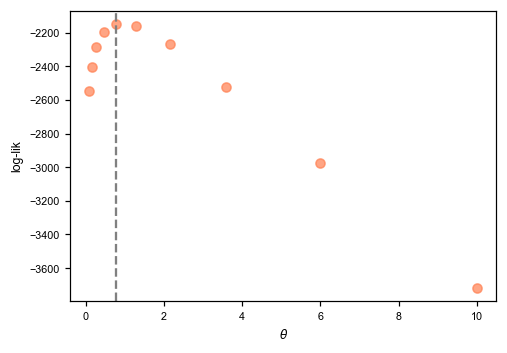

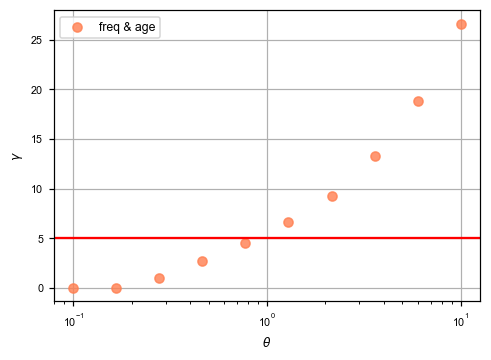

In [341]:
## figuring out the right theta to use for s
thetas = np.logspace(-1,1,10)
# gtff, ltff = [], []
gtfa, ltfa = [], []
for t in thetas:
    # res = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},400),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ltff.append(res.fun)
    # gtff.append(10**res.x)
    res = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':50000},400),tol=1e-2,bracket=(-2,3))
    ltfa.append(res.fun)
    gtfa.append(10**res.x)

# plt.scatter(np.linspace(100,2000,12)[:-1],-np.array(ltff),color='deepskyblue',alpha=0.7,); plt.grid(); plt.xlabel(r'$\theta$'); plt.axvline(np.linspace(100,2000,12)[:-1][np.argmin(ltff)],color='grey',ls='--'); plt.show()
plt.scatter(thetas,-np.array(ltfa),color='coral',alpha=0.7,); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.axvline(thetas[np.argmin(ltfa)],color='grey',ls='--'); plt.show()
# plt.scatter(np.linspace(100,2000,12)[:-1],gtff,color='deepskyblue',alpha=0.8,label='freq only'); plt.axhline(15,color='red'); plt.xlabel(r'$\theta$'); 
plt.scatter(thetas,gtfa,color='coral',alpha=0.8,label='freq & age'); plt.ylabel(r'$\gamma$'); plt.legend(); plt.axhline(5,color='red'); plt.xlabel(r'$\theta$'); plt.grid(); plt.semilogx(); plt.show()
# thetas[np.argmin(ltff)]

In [584]:
## log-lik 2D surface over theta and gamma
thetas = np.logspace(-1,1,12)
gammas = np.logspace(-1,2,12,base=10)
ll2d = np.zeros((len(thetas),len(gammas)))
for it, t in enumerate(thetas):
    for ig, g in enumerate(gammas):
        ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':50000},400)

plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,12,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,12,3),labels=np.round(gammas[::3],1)); plt.plot(8,4,'kx'); plt.axvline(8.3,color='red')

# thetas = np.logspace(1,3,12)
# gammas = np.logspace(-1,2,12,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqconstant(np.log10(g),{'sfs':sfs,'theta':t,'p_misid':0},400)

# plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,12,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,12,3),labels=np.round(gammas[::3],1)); plt.plot(7,9,'kx'); plt.axvline(8.3,color='red'); plt.axhline(8.7,color='red')

KeyboardInterrupt: 

In [603]:
ll2d[0,:].min(), get_ll_freqageconstant(np.log10(10),{'sms':SMSmask,'theta':1,'N':10000,'p_misid':0,'gens':20000},400)

(1615.3548365482436, 1612.5378727362493)

In [651]:
# np.histogram(df1['gamma'],bins=[0,0.5,5,50,200])[0]/len(df1)
# plt.scatter(np.sort(df1['s']),np.sort(sp.stats.gamma.rvs(0.2,scale=400,size=len(df1))/2000))
# sm.qqplot(df1['s']*20000,sp.stats.distributions.gamma(0.2,scale=400),label=r'simulated (shape=0.2,scale=400)',line='45'); 
# sm.qqplot(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=2000$')
# sm.qqplot(sp.stats.gamma.rvs(0.216,scale=5363,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=1700$')
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.091
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.216,scale=1286,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.047

0.17421

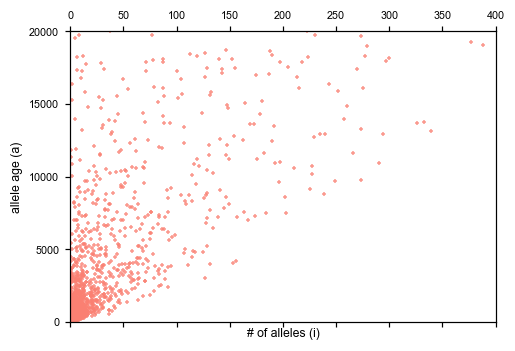

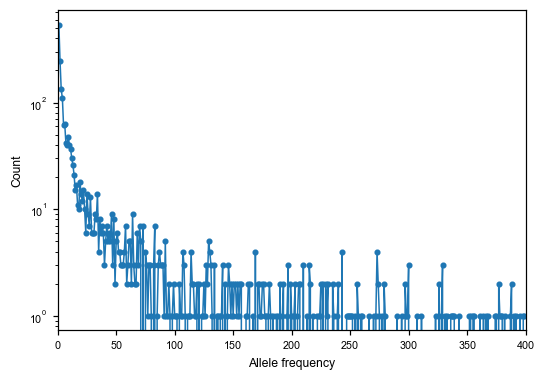

In [56]:
df1 = pd.read_csv("outfiles/gammaHuber17Unif.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*400)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = 50000+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

SMS = np.zeros((50000,400+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,402))[0])
moments.Plotting.plot_1d_fs(sfs)

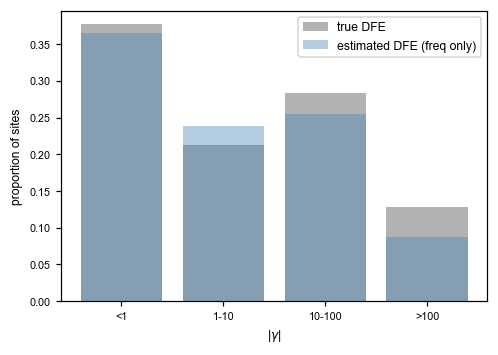

In [259]:
## get simulated distribution of gamma (bins: <1, 1-10, 10-100, >100)
# df1['gamma'] = df1['s']*20000
# plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'observed $\gamma$')
# df1['gamma_inf'] = sp.stats.gamma.rvs(0.174,scale=200,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>1) & (df1['gamma_inf']<10))/len(df1),np.sum((df1['gamma_inf']>10) & (df1['gamma_inf']<100))/len(df1),np.sum(df1['gamma_inf']>100)/len(df1)],color='steelblue',alpha=0.6,label=r'simulated $\gamma$'); plt.legend()
# plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')

df1['gamma'] = sp.stats.gamma.rvs(0.2,scale=200,size=len(df1)) #df1['s']*20000
plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'true DFE')
df1['gamma_inf'] = sp.stats.gamma.rvs(0.189,scale=320,size=len(df1))
plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>2) & (df1['gamma_inf']<20))/len(df1),np.sum((df1['gamma_inf']>20) & (df1['gamma_inf']<200))/len(df1),np.sum(df1['gamma_inf']>200)/len(df1)],color='steelblue',alpha=0.4,label=r'estimated DFE (freq only)'); 
plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')
# df1['gamma_inf3'] = sp.stats.gamma.rvs(0.177,scale=383,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf3']<2)/len(df1),np.sum((df1['gamma_inf3']>1) & (df1['gamma_inf3']<10))/len(df1),np.sum((df1['gamma_inf3']>10) & (df1['gamma_inf3']<100))/len(df1),np.sum(df1['gamma_inf3']>100)/len(df1)],color='salmon',alpha=0.4,label=r'estimated DFE (freq & age)'); 
plt.legend()

In [1191]:
# my_cmap = copy(cm.get_cmap('viridis'))
# my_cmap.set_bad(my_cmap.colors[0])
# Nc = np.linspace(10000,12000,250,dtype='int')
# temp = run_mom_iterate_changing(1000, gamma[-1], Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# temp = run_mom_iterate_constant(len(Nc), 1000, gamma[-1]*0.5/Nc[0], 15000, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# plt.imshow(fsa,aspect='auto',interpolation='nearest',norm=colors.LogNorm(vmin=1e-10),); plt.colorbar()

array([[98210,     1],
       [98210,     2],
       [98210,     3],
       ...,
       [99364,   185],
       [99365,   184],
       [99365,   185]])

In [264]:
## creating a database of P(X, a | s) with dicts for different s values
# n = 200
# cutoff = 1
# del up_xa_s
# gammas = np.logspace(-3,3,15)
# up_xa_s = {}
# up_xa_s[0.0] = run_mom_iterate_constant(50000, 200, 0, 10000, 4, {})
# for ig, g in enumerate(gammas):
#     fsa = run_mom_iterate_constant(50000, 200, -2*g/10000, 10000, 4, {})
#     fsa[(fsa<0) | (fsa>10)] = 0
#     up_xa_s[g] = fsa

# del p_xa_s
p_xa_s = {}
for g in np.append(gammas,0):
    fs = moments.LinearSystem_1D.steady_state_1D(5000, gamma=-2*g)
    fs = moments.Spectrum(fs)
    fs.integrate([1], 3, gamma=-2*g, theta=800) ## for constant stuff 
    fs = fs.project([200])
    fsa[(fsa<0) | (fsa>10)] = 0 
    p_xa_s[g] = fs

In [263]:
sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.5,500]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':50000}),)
# sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.6,100]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200),bounds=((-2,0),(0,4)))
# theta = np.geomspace(1,50000,20)
# lltheta_age = []
# lltheta_freq = []
# for t in theta:
#     lltheta_freq.append(-get_ll_freqchanging(np.log10([0.2,2000]),({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00,'theta':t})))
#     lltheta_age.append(-get_ll_freqagechanging(np.log10([0.2,2000]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.00,'theta':t})))

# get_ll_freqchanging(np.log10([0.2,200]),({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00})) 
# get_ll_freqagechanging(np.log10([0.1,1700]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0.00,'gens':50000}))

# plt.scatter(theta, lltheta_freq, color='deepskyblue', alpha=0.6, label='freq only'); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); 
# plt.title(r'holding $(\alpha,\beta)$ at MLE'); plt.yscale('symlog'); plt.semilogx(); plt.grid(); plt.axvline(2000,color='k',ls='--',alpha=0.6,label='simulated')
# plt.scatter(theta, lltheta_age, color='coral', alpha=0.6, label='freq & age'); plt.legend(); 

      fun: 415.39229524255825
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.000, 0.000])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 11
     njev: 24
   status: 0
  success: True
        x: array([-0.722, 2.124])

In [408]:
## set up a framework for estimation of gamma for point DFE
## (all this requires is calculating the res for each value of g)
theta = np.geomspace(100,5000,15)
res_t = np.zeros((len(theta),2))
ll_t = np.zeros((len(theta),2))
nzidx = SMS.nonzero()
for it, t in enumerate(theta):
    res_f = np.zeros(len(gammas))
    res_a = np.zeros(len(gammas))
    for ig, g in enumerate(gammas):
        for i in range(1,len(sfs)-1):
            res_f[ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
        for i in range(len(nzidx[0])):
            res_a[ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)
    ll_t[it,0] = np.nanmax(res_f)
    ll_t[it,1] = np.nanmax(res_a)
    res_t[it,0] = gammas[np.nanargmax(res_f)]
    res_t[it,1] = gammas[np.nanargmax(res_a)]

# theta = np.geomspace(100,1e6,15)
# ll_tf = np.zeros((len(theta),len(gammas)))
# ll_ta = np.zeros((len(theta),len(gammas)))
# nzidx = SMS.nonzero()
# for it, t in enumerate(theta):
#     for ig, g in enumerate(gammas):
#         ll_tf[it,ig] = (-t*p_xa_s[g][:-2] + np.log(t*p_xa_s[g][:-2]) * sfs - sp.special.gammaln(sfs+1)).sum()
#         # for i in range(1,len(sfs)-1):
#         #     ll_tf[it,ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
#         for i in range(len(nzidx[0])):
#             ll_ta[it,ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)

In [617]:
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':2000,'p_misid':0}),tol=1e-1,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':5000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100}),tol=1e-1,bracket=(-2,3))
# get_ll_freqageconstant(np.log10(1e-20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100})

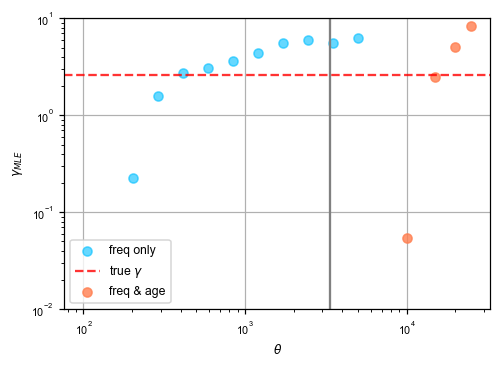

In [626]:
plt.scatter(np.geomspace(100,5000,12),res_t[:,0],alpha=0.6,color='deepskyblue',label='freq only'); plt.axhline(2.64,color='red',ls='--',alpha=0.8,label=r'true $\gamma$'); 
# plt.scatter(theta[ll_t.argmax(axis=0)[0]],res_t[ll_t.argmax(axis=0)[0],0],color='deepskyblue',marker='*',s=200); 
plt.ylim(1e-2,1e1); #plt.xlim(500,1e4)
# plt.scatter(theta[ll_t.argmax(axis=0)[1]],res_t[ll_t.argmax(axis=0)[1],1],color='coral',marker='*',s=200); 
plt.axvline(sfs.sum()*2/p_xa_s[0].sum(),color='grey')
plt.scatter(theta,res_t[:5,1],alpha=0.8,color='coral',label='freq & age'); plt.grid(); plt.loglog(); plt.xlabel(r'$\theta$'); plt.ylabel(r'$\gamma_{MLE}$'); plt.legend(); 

# plt.imshow(ll_tf-np.nanmax(ll_tf),cmap='cividis',vmin=-100); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));
# plt.show()
# plt.imshow(ll_ta-np.nanmax(ll_ta),cmap='cividis',vmin=-200); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));

In [201]:
## inference procedure for gamma, but only point DFE (does this work first? Yes, it does!)
nsims = 3
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=3500)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = len(Nc) + 1 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*20000

    dub_onlyfreq, dub_onlyage = np.zeros((len(gamma))), np.zeros((len(gamma))) 
    for ig, g in enumerate(gamma):
        dub_onlyfreq[ig] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
        dub_onlyage[ig] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))

    mlefreq.append(np.argmax(dub_onlyfreq))
    mleage.append(np.argmax(dub_onlyage))

In [202]:
gamma[mlefreq]*1e5, gamma[mleage]*1e5, -0.00025*1e5
# np.sum(get_lp_alxl(up_xa_s, gamma[-0], dat[:,5], dat[:,3], cutoff=2))

(array([-26.334, -26.334, -26.334]), array([-26.334, -26.334, -18.987]), -25.0)

In [356]:
## code to convert PReFerSim sfs_out file to dadi sfs in file
prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
dadisfs = np.zeros((200+1,)).astype('int')
for n in range(0, len(prfsim.columns)-1):
    dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

f = open("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt", "w")
f.write("201 unfolded\n")
f.write(' '.join(map(str, dadisfs)))
f.close()

In [61]:
## fitdadi framework for DFE inference
# sel_params = [0.5, 1000.]
# lower_bound, upper_bound = [1e-3, 1.], [1, 5000.]
# p0 = dadi.Misc.perturb_params(sel_params,lower_bound=lower_bound,upper_bound=upper_bound)
# def DemoTenn12(params, ns, pts):
#     N1,T1,N2,T2,NC,TC, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 0.01, N1, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, T2, N2, gamma=gamma)
#     nu_func = lambda t: N2*np.exp(np.log(NC/N2)*t/TC)
#     phi = dadi.Integration.one_pop(phi, xx, TC, nu_func, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs
# def DemoConstant(params, ns, pts):
#     N1, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 6, N1, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs

# spectra = dadi.DFE.Cache1D([0.5], [1000], DemoConstant, pts_l=[1500], gamma_bounds=(1e-3, 500), gamma_pts=20, verbose=True, mp=False)

# popt, llopt = dadi.Inference.opt(p0, data, spectra.integrate, pts=None, func_args=[DFE.PDFs.gamma, 100], lower_bound=lower_bound, upper_bound=upper_bound, verbose=len(sel_params), maxtime=10, multinom=True)
# print(popt, llopt)

# model_sfs = spectra.integrate(popt, None, DFE.PDFs.gamma, 100, None)
# moments.Plotting.plot_1d_fs(model_sfs)

In [842]:
## moments framework for DFE inference
## A couple of outstanding questions:
# 1. what does dxs do? 
# 2. is theta a big deal here?
# 3. increase the number AND range of gamma values
# 4. include pmis...
# WHY IS moments NOT WORKING EITHER??? is the biggest question
data = moments.Spectrum.from_file("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt")
def selection_spectrum(gamma, h=0.5):
    ns_sim = 10000
    fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
    ## define the optimal demo parameters here
    fs = moments.Spectrum(fs)
    fs.integrate([0.5], 6, gamma=gamma)
    fs = fs.project([200]) 
    # fs[fs<0] = np.min(np.abs(fs))
    return fs

# spectrum_cache = {}
# spectrum_cache[0] = selection_spectrum(0)

# gammas = np.logspace(-3, 3, 30)
# for gamma in gammas:
#     spectrum_cache[gamma] = selection_spectrum(-gamma)

# p_xa_s = {}
# for g in list(spectrum_cache.keys()):
#     p_xa_s[-g] = spectrum_cache[g]/np.sum(spectrum_cache[g])
#     p_xa_s[-g][p_xa_s[-g]<0] = 1e-250

# dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2 + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=600):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return fs 

opt_params_mis = moments.Inference.optimize_log_fmin([0.5,1000], data, dfe_func, lower_bound=[1e-3,1], upper_bound=[1,50000], multinom=True, maxiter=200)
print(opt_params_mis, moments.Inference.ll_multinom(dfe_func(opt_params_mis,200,1000),data))

[0.185 49997.302] -402.212477299273


In [91]:
# sp.special.logsumexp(llage,b=wt), np.log(np.sum(wt*np.exp(llfreq)))
# plt.plot(llfreq-llfreq.max()); plt.plot(llage-llage.max()); plt.ylim((-10,0))
# plt.scatter(dat[:,5], dat[:,3])
# a1, b1 = np.log(np.linspace(0.1,0.5,2)), np.linspace(0.4,0.6,2) # -> this is the ~real deal~
# np.log(np.sum(np.exp(a1)*b1)), sp.special.logsumexp(a1,b=b1)
# llfreq, llage
# get_ll_freqchanging(np.log([1,1]),({'p_xa_s':p_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5]}))

array([0.026, 0.062, 0.082, 0.109, 0.146, 0.195, 0.259, 0.346, 0.461,
       0.615, 0.820, 1.094, 1.459, 1.946, 2.595, 3.460, 4.614, 6.153,
       8.205, 10.941, 14.591, 19.457, 25.946, 34.600, 19.773])

In [46]:
# fsa = np.zeros_like(up_xa_s[gamma[-1]])
# fs = np.zeros_like(p_xa_s[gamma[-1]])
# weights = sp.stats.gamma.pdf(-40000*gamma, alpha[1], scale=beta[1])
# for g, dx, w in zip(gamma, dxs, weights):
#     fs += p_xa_s[g] * dx * w
#     fsa += up_xa_s[g] * dx * w

# plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar();  plt.show()
# moments.Plotting.plot_1d_fs(fs)
# get_ll_xl(fs, dat[:,5]), get_ll_xl_al(fsa, dat[:,5], dat[:,2]) 
# get_ll_freqchanging([np.log(0.1),np.log(1000)],{'p_xa_s':p_xa_s,'N0':20000,'gamma':gamma,'sXlred':dat[:,5]})
# get_ll_freqagechanging(np.log([a,b]),({'up_xa_s':up_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5],'alred':dat[:,3]}))
# get_ll_freqagechanging([np.log(0.1),np.log(1000)],{'up_xa_s':up_xa_s,'N0':40000,'gamma':gamma,'sXlred':dat[:,5],'alred':dat[:,3]})

4678018.894154326

In [888]:
## inference procedure basically means integrating over different values of alpha & beta producing a certain gamma using the appropriate prior (Gamma dist)
## implement sth about weighting (dx*wt) the entire SFS instead of just the sum? and then passing it along to the optim func
alpha, beta = np.linspace(0.1,0.3,10), np.linspace(50,1000,10)
nsims = 1; theta=1
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    # df1 = pd.read_csv("outfiles/gammaHuber17Const.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=2000)
    # df1['sXl'] = df1['Xl']*1000
    # df1['al'] = 80000+1 - df1['al']
    # dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta))) 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            # dub_onlyfreq[ia,ib] = get_ll_freqchanging(np.log10([a,b]),({'p_xa_s':p_xa_s,'gamma':np.logspace(-3,3,15),'sfs':sfs,'p_misid':0.00})) 
            dub_onlyage[ia,ib] = get_ll_freqagechanging(np.log10([a,b]),({'up_xa_s':up_xa_s,'gamma':np.logspace(-2,3,15),'sms':SMSmask,'p_misid':0.00,'gens':50000}))

    # mlefreq.append(np.unravel_index(np.argmin(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmin(dub_onlyage,axis=None),dub_onlyage.shape))

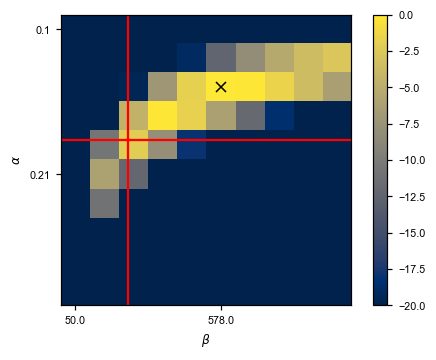

In [917]:
# plt.imshow(dub_onlyfreq-np.nanmax(dub_onlyfreq),vmin=-2); plt.title(r'True value $(\alpha,\beta)=(0.2,400)$'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.show()
# plt.imshow(dub_onlyage-np.max(dub_onlyage),vmin=-10); plt.colorbar(); plt.title(r'True value $(\alpha,\beta)=(0.18,2000)$'); plt.xticks(ticks=range(0,len(beta),3),labels=np.round(beta[::3])); plt.yticks(ticks=range(0,len(beta),3),labels=np.round(alpha[::3],2)); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$')

# plt.imshow(-dub_onlyfreq+np.min(dub_onlyfreq),vmin=-100,cmap='cividis'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.axvline(2.1,color='red'); plt.axhline(1.8,color='red'); plt.plot(mlefreq[0][1],mlefreq[0][0],'kx'); plt.show()
# plt.imshow(-dub_onlyage+np.min(dub_onlyage),vmin=-20,cmap='cividis'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.axvline(1.8,color='red'); plt.axhline(3.8,color='red'); plt.plot(mleage[0][1],mleage[0][0],'kx'); plt.show()

# get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2)
# ?plt.plot

In [985]:
# np.argwhere(dub_onlyfreq==np.min(dub_onlyfreq[:8,:])), np.argwhere(dub_onlyage==np.min(dub_onlyage[:8,:]))

0.09481370881380784

In [122]:
# plt.plot(sp.stats.gamma.ppf(np.linspace(0.05,0.95,10),0.1,scale=100),np.array([sp.stats.gamma.ppf(np.linspace(0.05,0.95,10),0.3,scale=1000),-24757*gamma[::2]]).T);
# sp.stats.gamma.ppf(np.linspace(0.05,0.95,10),0.3,scale=100)
# np.unravel_index(np.argmin(dub_onlyfreq,axis=None),dub_onlyfreq.shape)

5000.0

In [79]:
mlefreq, mleage
# (-1,-1): [-88484.88913002703, -132081.62912621396], (-10,-10): [-88457.24606171598, -132053.98605790292], (0,0): [-88432.95850947323, -132029.69850566017]
# lika1b1 = [0,0]
# for g in gamma:
#     lika1b1[0] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2)) + sp.stats.gamma.logpdf(-g,alpha[0],scale=beta[0])
#     lika1b1[1] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2)) + sp.stats.gamma.logpdf(-g,alpha[0],scale=beta[0])
# print(lika1b1)
# np.sum(get_lp_xl(p_xa_s, gamma[-1], dat[:,5], cutoff=1)) 

([(19, 0)], [(19, 0)])

In [383]:
## inference procedure using CDF instead of PDF (following Ortega-Del Vecchyo et al 2022 procedure)
alpha, beta = np.linspace(0.1,0.3,20), np.linspace(100,1000,20)
nsims = 2
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=1500)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = 92516 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*24757
    dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta)))
    llfreq = get_lp_xl(p_xa_s, g, dat[:,5], cutoff=1)
    llage = get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2)

    tau = -150 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            wt = np.log([sp.stats.gamma.cdf(-24757*g+0.5,a,scale=b)-sp.stats.gamma.cdf(-24757*g-0.5,a,scale=b) if g>tau else 1-sp.stats.gamma.cdf(-tau+0.5,a,scale=b) for g in gamma])
            for g, w in zip(gamma, wt):
                dub_onlyfreq[ia, ib] += (llfreq + w).sum()
                dub_onlyage[ia, ib] += (llage + w).sum()

    mlefreq.append(np.unravel_index(np.argmax(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmax(dub_onlyage,axis=None),dub_onlyage.shape))